In [6]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import time

# Maxflow problem

The maximum flow problem involves computing the maximum feasible flow from a designated source node to a sink node in a directed graph, subject to capacity limits on the edges and flow conservation at intermediate nodes (i.e., no accumulation of flow at any node except the source and sink). The maxflow problem can be visualized as graph with weighted edge represent the maximum flow possible through the edge.  

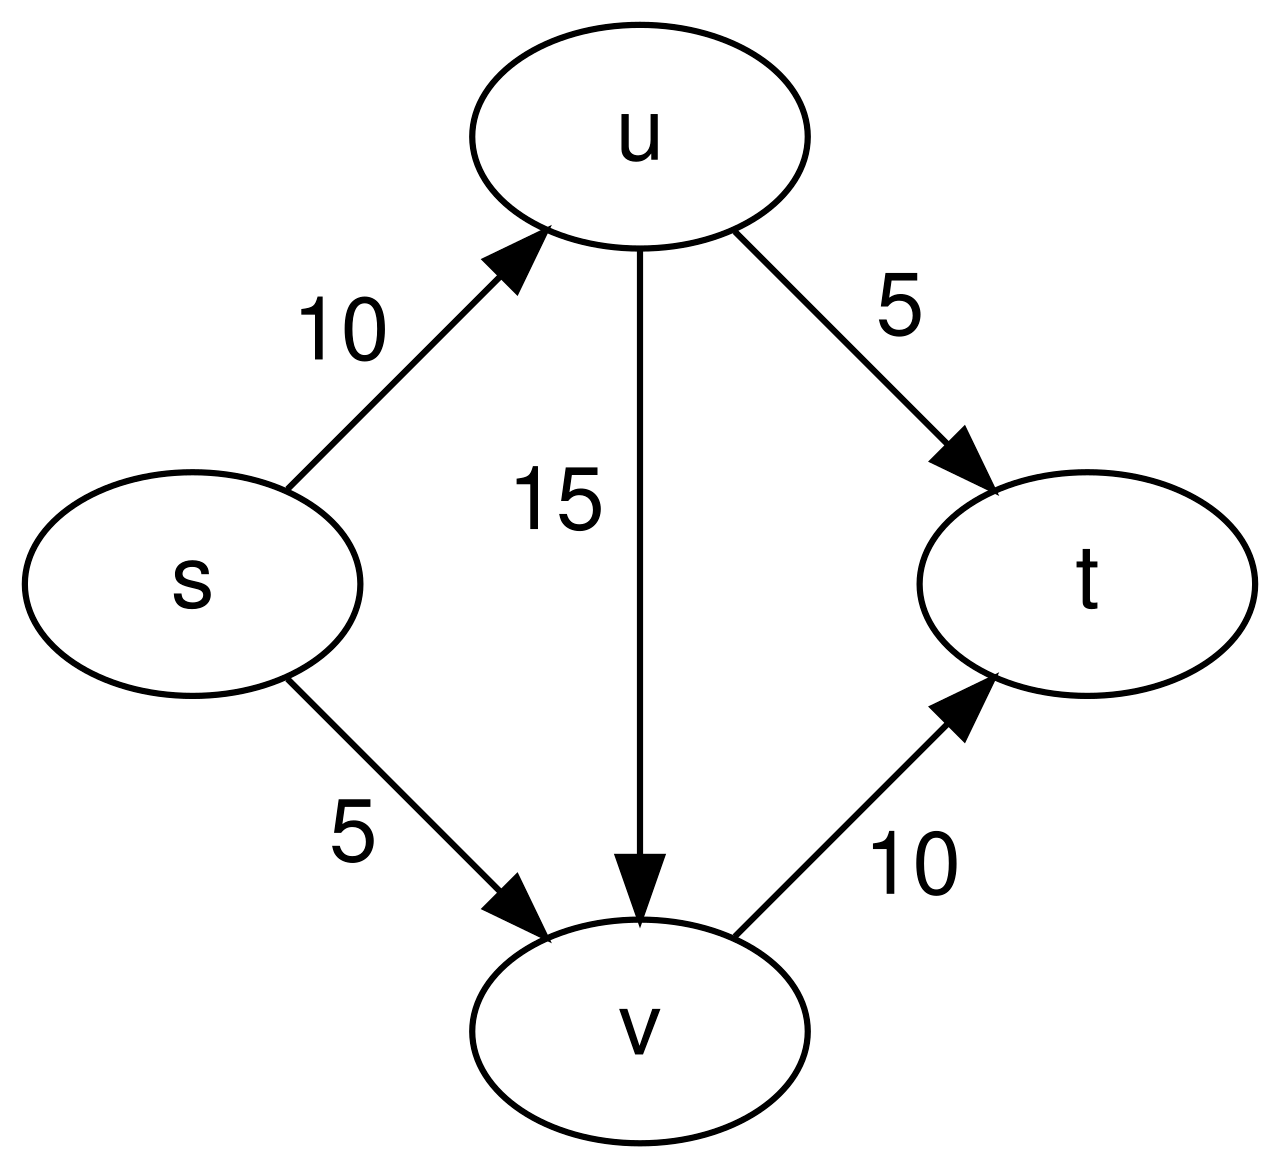
Example of maxflow problem 

Ref : https://en.wikipedia.org/wiki/Maximum_flow_problem#/media/File:Simpe_flow_network.svg
$$
\begin{aligned}
\text{maximize} \quad & f_{sv} \\
\text{subject to} \quad 
& 0 \leq f_{uv} \leq c_{uv}, \quad \forall (u, v) \in E, \\
& \sum_{u: (u, v) \in E} f_{uv} = \sum_{w: (v, w) \in E} f_{vw}, \quad \forall v \in V \setminus \{s, t\}.
\end{aligned}
$$
The maxflow problem can be solved using **linear programming**. The maximization problem can be refomulated as a minimization problem and the inequality can be generalized by conic constraint. $\mathcal{K}$ is the cone representing the inequality constraint. 
$$
\begin{aligned}
\text{minimize} \quad & c^T x \\
\text{subject to} \quad & A x = b \\
                        & x \in \mathcal{K}
\end{aligned}
$$


In [7]:
A = np.array([[1, 0, -1, 0, 0],
              [0, 1, 0, -1, 0],
              [0, 0, 1, 0, -1]])
b = np.array([1,1,0])
c = np.array([2,3,5,1,1])

In [8]:
def maxflow(A,b,c,f,l):
    n = c.shape[0] # Size of the problem

    # Define the variables
    x = cp.Variable(n)
    # Define the objective
    objective = cp.Minimize(c.T @ x)

    # Define the constraints
    constraints = [A @ x == b,  # Linear equality constraint
                x[f:f+l] >= 0]  # Cone constraint
    problem = cp.Problem(objective, constraints) # Define the problem    

    problem.solve() # Solve the problem
    print("Is the solution optimal : ", problem.status)

    print("Optimal value:", problem.value)
    print("Optimal x:", x.value,'\n')

In [9]:
maxflow(A,b,c,2,3)

Is the solution optimal :  optimal
Optimal value: 4.999999999999999
Optimal x: [ 1.00000000e+00  1.00000000e+00 -9.08614504e-17 -9.08618821e-17
 -9.08614281e-17] 



The maximum flow problem is solved for various problem sizes.

In [10]:
mat = scipy.io.loadmat('maxflow.mat')
data = mat['MaxFlow']

In [11]:
n = data.shape[0]
for i in range(n):
    content = data[i][0][0][0]
    A = content[0].toarray()
    b = content[1].flatten()
    c = content[2].toarray()
    f = content[3][0][0][0][0][0]
    l = content[3][-1][-1][-1][-1][-1]
    print('Max flow problem',i+1,'\n')
    print('Size of problem : ', A.shape,'\n')
    init =time.time()
    maxflow(A,b,c,f,l)
    final = time.time()
    print('Time required',final-init,'\n')  

Max flow problem 1 

Size of problem :  (1000, 2457) 

Is the solution optimal :  optimal
Optimal value: 56.99999998734151
Optimal x: [-9.23807819e-08 -1.13563606e-09 -2.06224962e-09 ... -5.77478711e-11
 -2.87062745e-11 -4.92325539e-11] 

Time required 0.09711050987243652 

Max flow problem 2 

Size of problem :  (2000, 4660) 

Is the solution optimal :  optimal
Optimal value: 69.000000009996
Optimal x: [-3.10708695e-08 -1.03039951e-07 -1.88828309e-07 ... -1.21945835e-10
 -6.10460283e-11 -1.20825892e-10] 

Time required 0.18760323524475098 

Max flow problem 3 

Size of problem :  (3000, 7136) 

Is the solution optimal :  optimal
Optimal value: 147.00000001645682
Optimal x: [-9.27234361e-08 -1.04713570e-07 -2.51070688e-08 ... -1.28421646e-10
 -7.78138513e-11  3.36152622e-10] 

Time required 0.398425817489624 

Max flow problem 4 

Size of problem :  (4000, 9492) 

Is the solution optimal :  optimal
Optimal value: 48.99999999744718
Optimal x: [-1.16690001e-07 -3.85142459e-08 -6.10629042

# Optimal Control Problem

We consider a linear dynamical system with state $x(t) \in \mathbb{R}^n $, for $ t = 0, \dots, N $, and actuator or input signal $ u(t) \in \mathbb{R} $, for $ t = 0, \dots, N - 1 $. The dynamics of the system are given by the linear recurrence:

$$
x(t+1) = A x(t) + b u(t), \quad t = 0, \dots, N - 1,
$$

where $ A \in \mathbb{R}^{n \times n} $ and $ b \in \mathbb{R}^n $ are given. We assume that the initial state is zero, i.e., $ x(0) = 0 $.

The **minimum fuel optimal control problem** is to choose the inputs $ u(0), \dots, u(N-1) $ so as to minimize the total fuel consumed, which is given by:

$$
F = \sum_{t=0}^{N-1} f(u(t))
$$

Subject to the constraint that $x(N) = x_{\text{des}}$, where $N$ is the (given) time horizon, and $x_{\text{des}} \in \mathbb{R}^n$ is the given desired final or target state.

The function $f : \mathbb{R} \to \mathbb{R}$ is the fuel use map for the actuator, and gives the amount of fuel used as a function of the actuator signal amplitude. In this problem, we use the following definition of $f(a)$:

$$
f(a) = 
\begin{cases}
|a|, & \text{if } |a| \leq 1 \\
2|a| - 1, & \text{if } |a| > 1
\end{cases}
$$


In [12]:
A = np.array([[-1, 0.4, 0.8],
              [1, 0, 0],
              [0, 1, 0]])
b = np.array([1,0, 0.3])
x_des = np.array([7,2,-6])

N = 30
n = A.shape[0]

The optimal control problem can be formulated as an optimization problem

$$
\begin{aligned}
\text{minimize} \quad & c^T \alpha \\
\text{subject to} \quad & \max\{|u(t)|,2|u(t)|-1\}\leq \alpha_t \\
                        & \alpha_t \geq 0 \\
                        & A x(t) - x(t+1) + b u(t) = 0 \quad \forall \quad t = 0, \dots, N-1 \\
                        & x(N) = x_{des}
\end{aligned}
$$

This can be written in vectorized form.
$$
\begin{aligned}
&\alpha  = [\alpha_0,\alpha_1,\alpha_2 \ldots \alpha_{N-1}]^T \\
&c  = [1,1,1 \ldots 1]^T \\
&\max\{|u(t)|,2|u(t)|-1\}\leq \alpha_t : eu(t)-j\alpha_t \leq h \\
& e = [1,-1,2,-2]^T \\
& j = [1,1,1,1]^T \\
& h = [0,0,1,1]^T \\
& A x(t) - x(t+1) + b u(t) = 0 \quad \forall \quad t = 0, \dots, N-1
\end{aligned}
$$
The equations can be changed into block matrix 
$$
\begin{bmatrix}
\mathbf{e} & 0 & 0 & \cdots \\
0 & \mathbf{e} & 0 & \cdots \\
0 & 0 & \mathbf{e} & \cdots \\
\vdots & \vdots & \vdots & \ddots
\end{bmatrix}\begin{bmatrix}
u(0)\\
u(1)\\
\vdots\\
u(N-1)\\
\end{bmatrix}-\begin{bmatrix}
\mathbf{j} & 0 & 0 & \cdots \\
0 & \mathbf{j} & 0 & \cdots \\
0 & 0 & \mathbf{j} & \cdots \\
\vdots & \vdots & \vdots & \ddots
\end{bmatrix}\begin{bmatrix}
\alpha_0\\
\alpha_1\\
\vdots\\
\alpha_{N-1}\\
\end{bmatrix} = \begin{bmatrix}
h\\
h\\
\vdots\\
h\\
\end{bmatrix} 
$$

$$
\begin{bmatrix}
\mathbf{A} & - \mathbf{I}& 0 & \cdots \\
0 & \mathbf{A} & - \mathbf{I} & \cdots \\
0 & 0 & \mathbf{A} & - \mathbf{I}& \cdots \\
\vdots & \vdots & \vdots & \ddots
\end{bmatrix}\begin{bmatrix}
x(0)\\
x(1)\\
\vdots\\
x(N-1)\\
\end{bmatrix}+\begin{bmatrix}
\mathbf{b} & 0 & 0 & \cdots \\
0 & \mathbf{b} & 0 & \cdots \\
0 & 0 & \mathbf{b} & \cdots \\
\vdots & \vdots & \vdots & \ddots
\end{bmatrix}\begin{bmatrix}
u(0)\\
u(1)\\
\vdots\\
u(N-1)\\
\end{bmatrix} = 0
$$

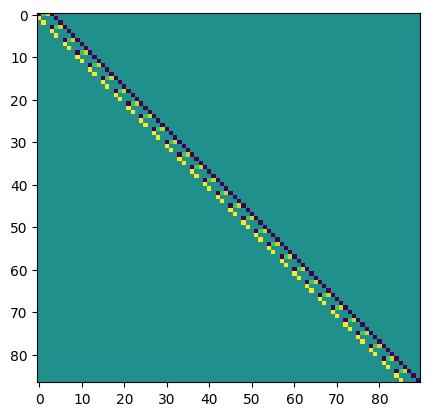

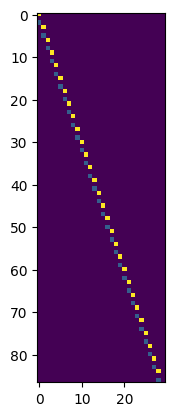

In [19]:
I = np.eye(n)
O = np.zeros((n,n))
O_vec = np.zeros(b[:,np.newaxis].shape) 


C_ocp = np.zeros((n,n*N))
C_ocp[:n,:n] = I

c_cost = np.ones(N)

e = np.array([1,-1,2,-2])
j = np.array([1,1,1,1])
h = np.array([0,0,1,1])

dim = e.shape[0]
E_ocp = np.zeros((dim*N,N))
J_ocp = np.zeros((dim*N,N))
H_ocp = []

for i in range(N):

    temp1 = np.hstack([O]*(i)+[A]+[-I]+[O]*(N-2-i))
    temp2 = np.hstack([O_vec]*(i)+[b[:,np.newaxis]]+[O_vec]*(N-i-1))

    if(i==0):
        A_ocp = temp1
        b_ocp = temp2
    else:
        if (i==N-1):
            continue
        else:
            A_ocp = np.vstack((A_ocp,temp1))
            b_ocp = np.vstack((b_ocp,temp2))

for i in range(N):
    H_ocp = np.hstack((H_ocp,h))
    E_ocp[i*dim:(i+1)*dim,i] = e
    J_ocp[i*dim:(i+1)*dim,i] = j
    
H_ocp = H_ocp.reshape(-1,1)

plt.imshow(A_ocp)
plt.figure()
plt.imshow(b_ocp)

prob_dim = N*n+1*N+1*N # Size of problem

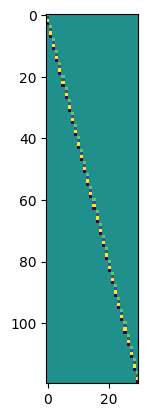

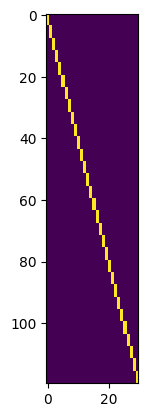

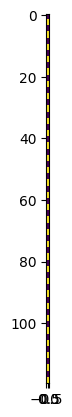

In [20]:
plt.imshow(E_ocp)
plt.figure()
plt.imshow(J_ocp)
plt.figure()
plt.imshow(H_ocp)

In [21]:
def LP_ocp(A,b,c,C,E,J,H,prob_dim,N,n,x_des):

    # Define the variables
    x = cp.Variable(prob_dim) # First nxN are states 0 : n*N, input : n*N:n*N+N, slack var:n*N+N:n*N+N+N
    

    # Define the objective
    objective = cp.Minimize(c.T @ x[n*N+N:n*N+N+N])

    # Define the constraints
    constraints = [A @ x[0 : n*N]+b@x[n*N:n*N+N] == 0,# Linear equality constraint
               x[0 : n] == 0,
               x[n*N-n:n*N] == x_des,
               E @ x[n*N:n*N+N]-J@x[n*N+N:n*N+N+N] <= H,
               x[n*N+N:n*N+N+N]>=0]  # Cone constraint
    problem = cp.Problem(objective, constraints) # Define the problem

    # Check if the problem is feasible
    

    problem.solve(cp.CLARABEL) # Solve the problem
    print("Is the solution optimal : ", problem.status)

    print("Optimal value:", problem.value)
    print("Optimal u(t):", x[n*N:n*N+N-1].value,'\n')

    
    time = np.linspace(0,N-1,N)
    values = x[n*N:n*N+N].value
    print('N-1 state :',x[n*N-n:n*N].value)
    print('0 state :',x[0:n].value)
    print('slack  :',x[n*N+N:n*N+N+N].value)
    print(A @ x[0 : n*N].value+b@x[n*N:n*N+N].value)
    print(x_des)
    # Create a step plot
    plt.step(time, values, where='post', color='b', linestyle='-', marker='o')

    # Add labels and title
    plt.xlabel('Time')
    plt.ylabel('u(t)')
    plt.title('Actuator input u(t)')

    # Show the plot
    plt.show()


Is the solution optimal :  optimal
Optimal value: 17.32356785747947
Optimal u(t): [ 2.04902371e-09 -4.84859640e-08  1.00000000e+00 -1.00000000e+00
  9.99999994e-01 -4.72046006e-09  4.07892717e-11  4.54124173e-09
 -9.99999993e-01  1.00000000e+00 -9.99999999e-01  2.46624032e-01
 -1.74572674e-09 -9.65987863e-10  1.21122540e-08 -9.99999996e-01
  1.00000000e+00 -9.99999993e-01  1.01955671e-08 -1.04262358e-10
 -1.52692030e-09  9.99999995e-01 -6.98881527e-01  1.00000000e+00
 -3.88550812e-09  1.39397513e-07  5.57306518e-09  4.63870014e-10
  3.18903106e+00] 

N-1 state : [ 7.  2. -6.]
0 state : [ 3.69134012e-15  1.48670938e-15 -3.47972476e-15]
slack  : [1.42524044e-09 4.73412353e-08 9.99999999e-01 1.00000000e+00
 9.99999993e-01 3.73428468e-09 5.48237885e-10 3.60580244e-09
 9.99999992e-01 9.99999999e-01 9.99999998e-01 2.46624030e-01
 1.18148308e-09 7.65510491e-10 1.10284354e-08 9.99999995e-01
 9.99999999e-01 9.99999992e-01 9.11723043e-09 5.51876164e-10
 1.04985993e-09 9.99999994e-01 6.98881526e-

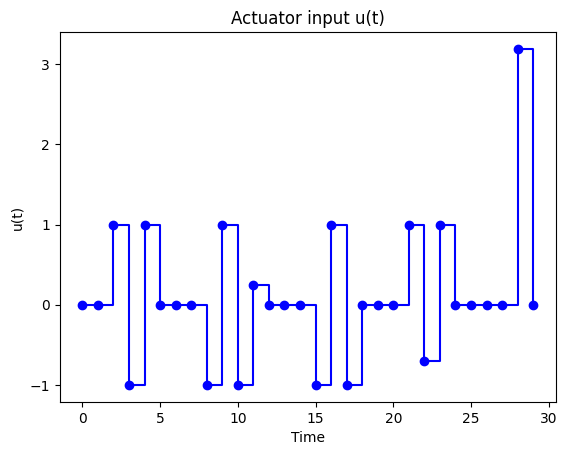

In [22]:
LP_ocp(A_ocp,b_ocp,c_cost,C_ocp,E_ocp,J_ocp,H_ocp,prob_dim,N,n,x_des)